# PyKOALA Data Reduction Sequence (Science data)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os
from koala import __version__
import warnings

# You may want to comment the following line
warnings.filterwarnings("ignore")

# pyKOALA version
print("pyKOALA version: ", __version__)

pyKOALA version:  0.6.0+0.g3d466f0.dirty


In [2]:
from koala.koala_ifu import koala_rss
from koala.corrections.atmospheric_corrections import AtmosphericExtCorrection, get_adr
from koala.corrections.throughput import Throughput, ThroughputCorrection
from koala.cubing import build_cube

atm_ext_corr = AtmosphericExtCorrection()

### Throughput correction

In [3]:
flat_rss = [koala_rss("../tests/reduced_data/385R/combined_skyflat_red.fits")]
throughput = ThroughputCorrection.create_throughput_from_rss(flat_rss, clear_nan=True)
throughput_corr = ThroughputCorrection(throughput=throughput)

Applying nearest neighbour interpolation to remove NaN values


### Telluric correction

We will use the correction function derived during the standard stars reduction sequence.

In [4]:
from koala.corrections.sky import TelluricCorrection

telluric_corr = TelluricCorrection(telluric_correction_file='products/telluric_correction_red.dat', verbose=True)

[Correction: TelluricCorretion] Obtaining telluric correction using spectrophotometric star...
[Correction: TelluricCorretion] Reading telluric correction from input file products/telluric_correction_red.dat


## Load the science data

In [5]:
from koala.koala_ifu import koala_rss

sci_rss = []
aaomega_arms = {'blue': 1, 'red': 2}
# Choose which arm of the spectrograph is going to be used
arm = 'blue'
path_to_data = 'data'

adr_x_set = []
adr_y_set = []
    
#for i in [31, 32, 33]:
for i in [34, 35, 36]:
    filename = f"../tests/reduced_data/385R/27feb200{i}red.fits"
    rss = koala_rss(filename)

    rss = throughput_corr.apply(rss)
    rss = atm_ext_corr.apply(rss)
    rss = telluric_corr.apply(rss)
    # Telluric
    # Sky
    
    adr_x, adr_y, fig = get_adr(rss, plot=True)
    adr_x_set.append(adr_x)
    adr_y_set.append(adr_y)
    print(f"File {filename} corresponds to object {rss.header['OBJECT']}")
    sci_rss.append(rss)

[Correction: TelluricCorretion] Applying telluric correction to this star...
File ../tests/reduced_data/385R/27feb20034red.fits corresponds to object He2-10 D 18S 3E
[Correction: TelluricCorretion] Applying telluric correction to this star...
File ../tests/reduced_data/385R/27feb20035red.fits corresponds to object He2-10 E 1.5E
[Correction: TelluricCorretion] Applying telluric correction to this star...
File ../tests/reduced_data/385R/27feb20036red.fits corresponds to object He2-10 F 1.5E 1.5S


## Registration

### Image Cross-correlation

The most sofisticated method to perform the registration of extended sources included in pyKOALA is based on the cross-correlation of two images.

from koala.register.registration import register_crosscorr

figures = register_crosscorr(sci_rss, plot=True, quick_cube_pix_size=1.)
for fig in figures:
    plt.show(plt.figure(fig))

### Centroid finding

A simple approach to find the offset between the different RSS is to find the center of light of the images (assuming that they contain the same sources).

from koala.register.registration import register_centroid

figures = register_centroid(sci_rss, plot=True, quick_cube_pix_size=0.2,
                            centroider='gauss',
                            #subbox=[[150, 200], [20, 100]]
                           )

for fig in figures:
    plt.show(plt.figure(fig))

### Manual

Alternatively, it is also possible to provide a manual offset for the input RSS frames

In [6]:
from koala.register.registration import register_manual

register_manual(sci_rss, [[0, 0], [1.5, 0], [3, 1.5]], absolute=False)

[Registration] Object:  He2-10 D 18S 3E
[Registration] Offset: [0, 0] (arcsec)
[RSS] Centre coords (129.0626, -26.4127) updated to (129.0626, -26.4127)
[Registration] Object:  He2-10 E 1.5E
[Registration] Offset: [1.5, 0] (arcsec)
[RSS] Centre coords (129.0632, -26.4128) updated to (129.0622, -26.4127)
[Registration] Object:  He2-10 F 1.5E 1.5S
[Registration] Offset: [3, 1.5] (arcsec)
[RSS] Centre coords (129.0632, -26.4131) updated to (129.0618, -26.4131)


In [7]:
cube = build_cube(rss_set=sci_rss,
                  reference_coords=(sci_rss[0].info['cen_ra'], sci_rss[0].info['cen_dec']),
                  reference_pa=0.,
                  cube_size_arcsec=(40, 60),  # (dec, ra)
                  pixel_size_arcsec=.5,
                  adr_x_set=adr_x_set, adr_y_set=adr_y_set)
cube.info['name'] = rss.info['name'].split(' ')[0]

[Cubing] Starting cubing process
[Cubing] 1-th RSS fibre (transformed) offset with respect reference pos:  (0.0, 0.0)  arcsec
[Cubing] 2-th RSS fibre (transformed) offset with respect reference pos:  (0.0, 0.0)  arcsec
[Cubing] 3-th RSS fibre (transformed) offset with respect reference pos:  (0.0, 0.0)  arcsec


## Sky substraction

In [8]:
import koala.corrections.sky as sky
import importlib
importlib.reload(sky)

skymodel = sky.SkyFromObject(cube, bckgr_estimator='mad', source_mask_nsigma=3, remove_cont=False)
skycorrection = sky.SkySubsCorrection(skymodel)
cube, _ = skycorrection.apply(cube)

[SkyModel]  Creating SkyModel from input Data Container
[SkyModel]  Estimating sky background contribution...
[SkyModel]  Pre-estimating background using all data
[SkyModel]  Applying sigma-clipping mask (n-sigma=3)
[Correction: SkyCorrection] Applying sky substraction


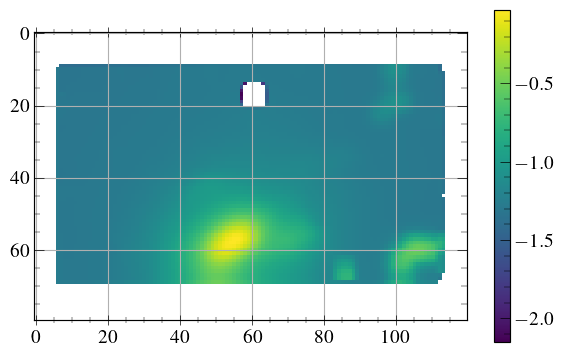

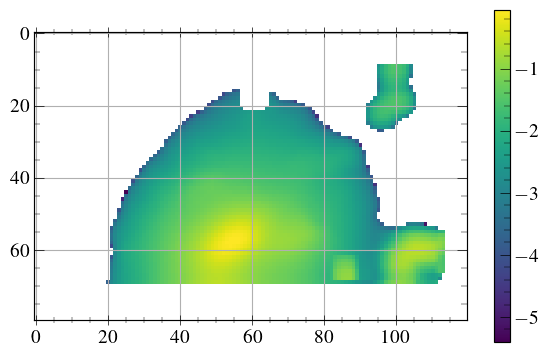

In [9]:
plt.figure()
plt.imshow(np.log10(np.nanmean(cube.intensity, axis=0)))
plt.colorbar()

plt.figure()
plt.imshow(np.log10(np.nanmean(cube.intensity_corrected, axis=0)))
plt.colorbar()

[QCPLOT] Cube QC plot for:  He2-10


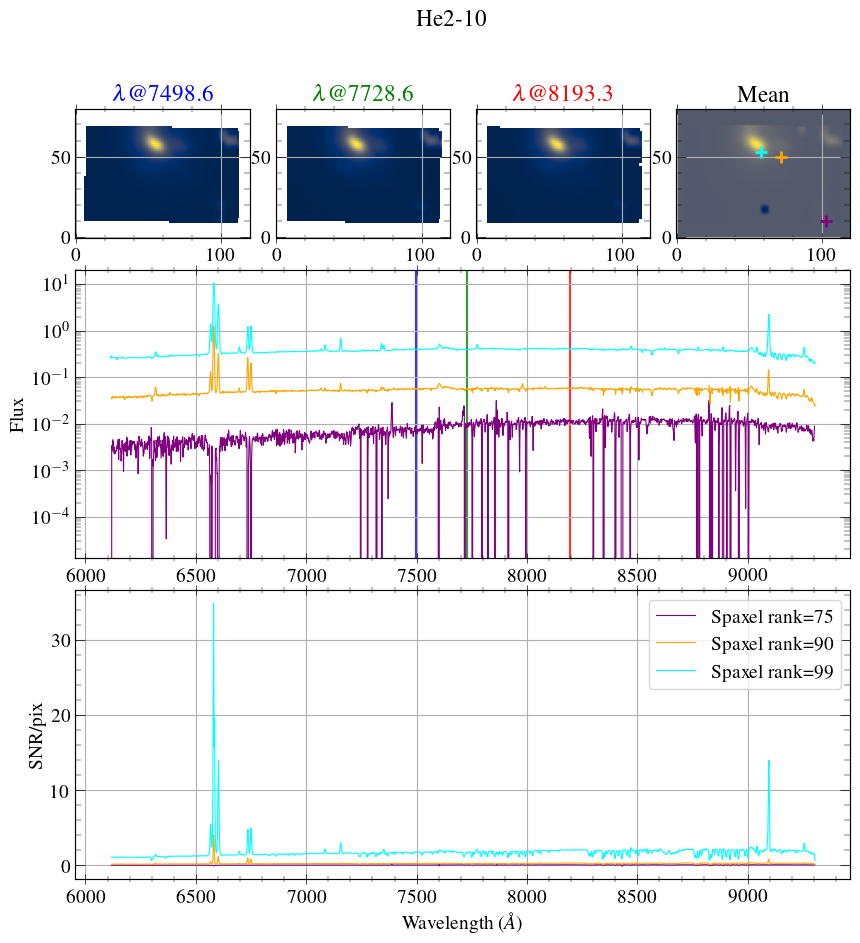

In [10]:
from koala.corrections.flux_calibration import FluxCalibration
from koala.plotting.qc_plot import qc_cube

#dummy_wave, dummy_response = np.loadtxt('data/instrument_response.dat', unpack=True)
#instrument_response = np.interp(cube.wavelength, dummy_wave, dummy_response)

#plt.figure()
#plt.plot(cube.wavelength, instrument_response)
#plt.ylabel("Reponse (1e-16 erg/s/cm2/AA/count)")
#fcal = FluxCalibration()
#fcal.apply(instrument_response, cube)

# you can save the cube using the following function
#cube.to_fits(fname=os.path.join(output, 'ngc1311.fits.gz'))
#%matplotlib

fig = qc_cube(cube)
plt.show(plt.figure(fig))

In [11]:
# Save the data cube
cube.to_fits("products/Henize_2-10_cube_no_sky.fits.gz")

[Saving] Cube saved at:
 products/Henize_2-10_cube_no_sky.fits.gz
